<a href="https://www.kaggle.com/code/mikedelong/python-plots-and-monthly-plots?scriptVersionId=138305990" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv(filepath_or_buffer='../input/maang-stock-prices-july-2018-to-july-2023/combined_file.csv', )
df = df[df['Name'] != 'Name']
for column in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
    df[column] = df[column].astype(float)
df['Volume'] = df['Volume'].astype(int)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date')
df.head()

,Name,Date,Open,High,Low,Close,Adj Close,Volume
0,AMZN,2018-07-30,91.366501,91.474998,88.301003,88.960999,88.960999,131246000
1,AMZN,2018-07-31,89.324501,90.091499,86.966003,88.872002,88.872002,114774000
2,AMZN,2018-08-01,89.199997,89.921997,88.801003,89.858498,89.858498,83062000
3,AMZN,2018-08-02,89.438499,91.828003,89.300003,91.716499,91.716499,87094000
4,AMZN,2018-08-03,91.887001,92.050003,91.074997,91.164497,91.164497,69210000


In [2]:
df.shape

(8806, 8)

In [3]:
df.dtypes

Name                 object
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: xlabel='Date', ylabel='Volume'>

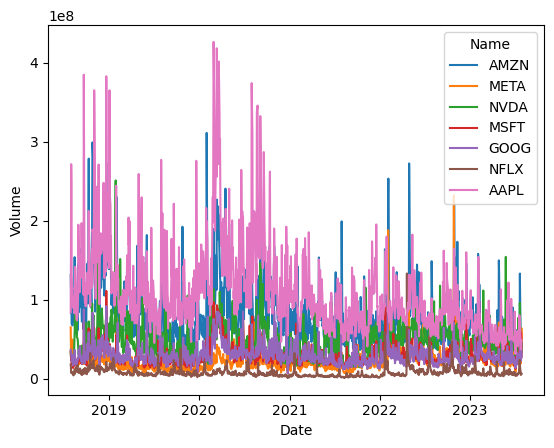

In [4]:
from seaborn import lineplot
lineplot(data=df, x='Date', y='Volume', hue='Name')

This is kind of messy; let's look at monthly volume instead

<Axes: xlabel='Date', ylabel='Volume'>

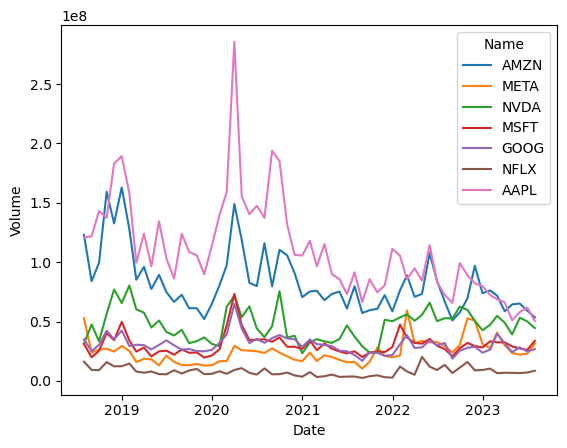

In [5]:
# we have daily volume, but monthly volume will give us a clearer picture
def get_monthly(arg_df, arg_name, value_name):
    result_df = arg_df[arg_df['Name'] == arg_name][[value_name]].resample('M').mean()
    result_df['Name'] = arg_name
    return result_df
monthly_volume_df = pd.concat([get_monthly(df[['Date', 'Name', 'Volume']].set_index('Date'), name, 'Volume') for name in df['Name'].unique()])
lineplot(data=monthly_volume_df, x='Date', y='Volume', hue='Name')

How big are the close adjustments?

<Axes: xlabel='Date', ylabel='Adj'>

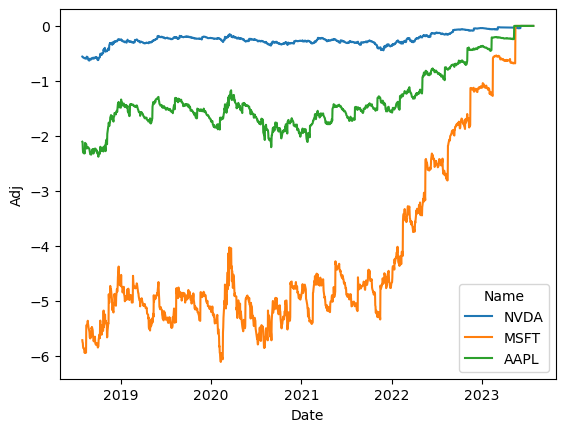

In [6]:
df['Adj'] = df['Adj Close'] - df['Close']
# only plot the issues with nonzero adjustment sums
adj_sum = {name: df[df['Name'] == name]['Adj'].sum() for name in df['Name'].unique()}
adj_sum = {key: value for (key, value) in adj_sum.items() if value != 0}
lineplot(data=df[df['Name'].isin(adj_sum.keys())], x='Date', y='Adj', hue='Name')

<Axes: xlabel='Date', ylabel='Adj Close'>

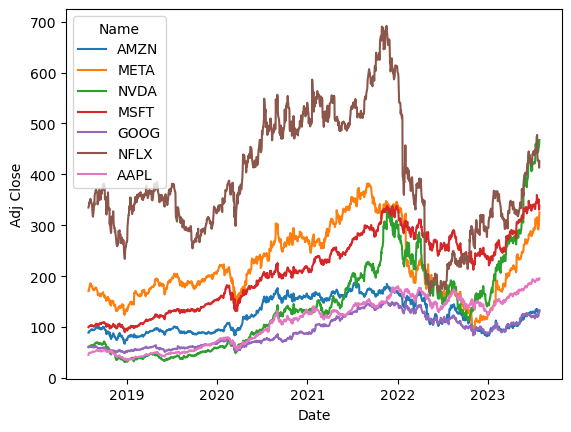

In [7]:
lineplot(data=df, x='Date', y='Adj Close', hue='Name')

Let's look at the daily returns based on the adjusted close; theys should be normalish.

/tmp/ipykernel_21/1375672412.py:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Adj Close_x', 'Name_x'} in the result is deprecated and will raise a MergeError in a future version.
  daily_return_df = daily_return_df.merge(right=name_df, on='Date')
/tmp/ipykernel_21/1375672412.py:9: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Adj Close_x', 'Name_x'} in the result is deprecated and will raise a MergeError in a future version.
  daily_return_df = daily_return_df.merge(right=name_df, on='Date')
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


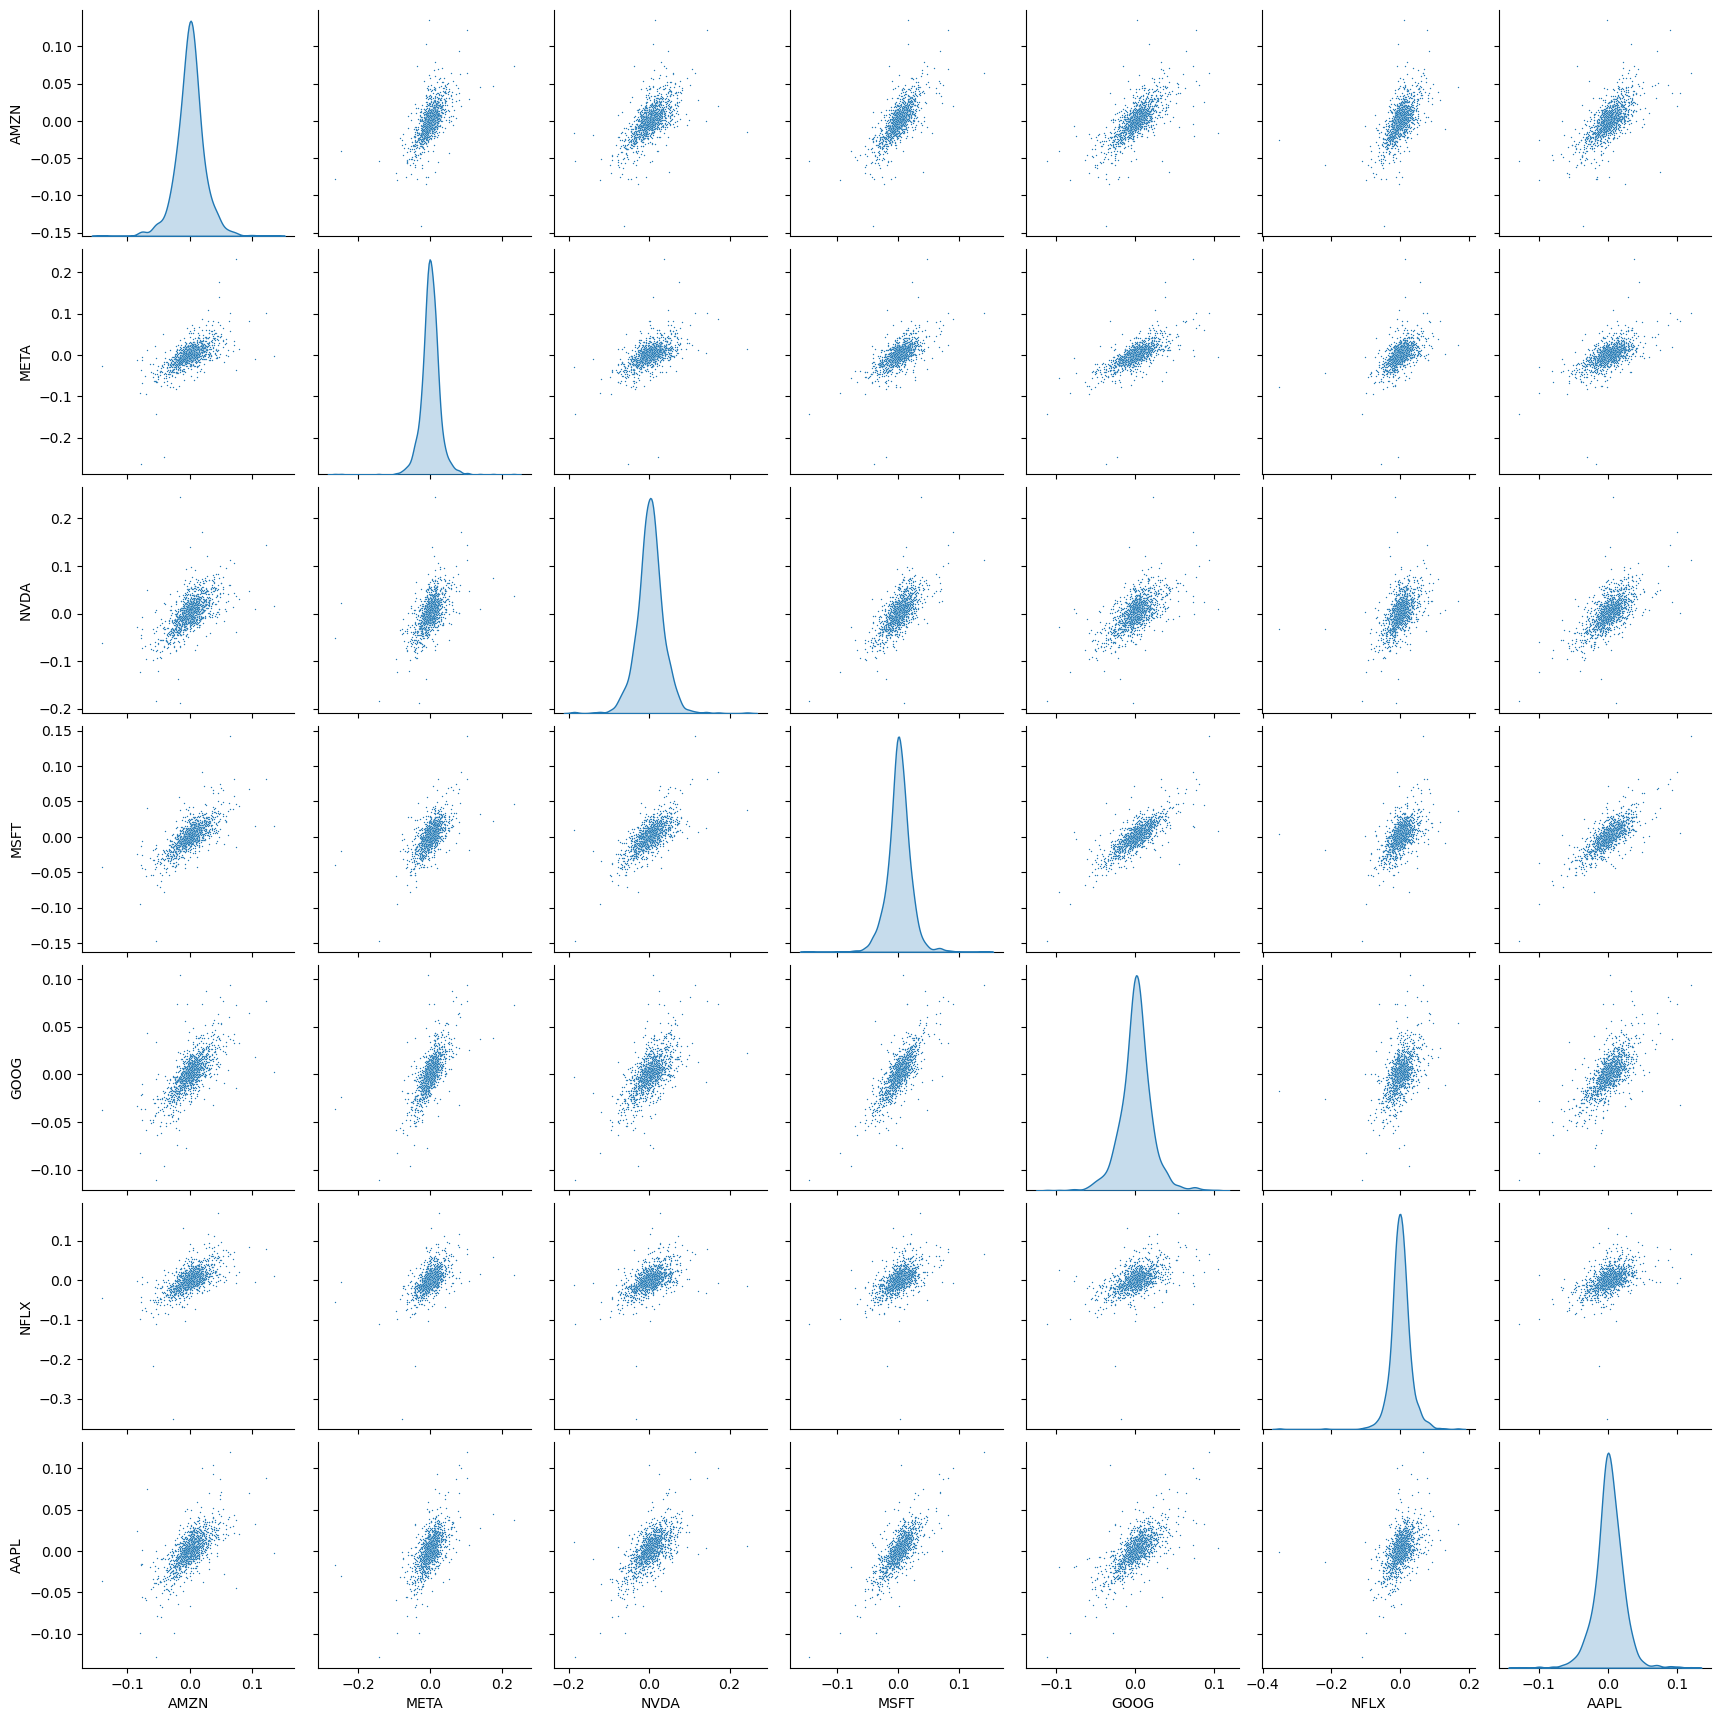

In [8]:
from seaborn import pairplot
def get_daily_return(arg_df, column):
    arg_df[column] = arg_df[column].pct_change(1)
    return arg_df

dfs = [get_daily_return(df[df['Name'] == name][['Date', 'Name', 'Adj Close']], 'Adj Close') for name in df['Name'].unique()]
daily_return_df = dfs[0].copy(deep=True)
for name_df in dfs[1:]:
    daily_return_df = daily_return_df.merge(right=name_df, on='Date')

daily_return_df = daily_return_df.drop(columns=['Name', 'Name_x', 'Name_y'])
daily_return_df.columns =  ['Date', 'AMZN', 'META', 'NVDA', 'MSFT', 'GOOG', 'NFLX', 'AAPL']

pairplot(data=daily_return_df, plot_kws={'s': 1}, diag_kind='kde')